# Moneyball Project Part 2: Money

In this section we will:

look at the new batting and salaries dataset, 
understand how to merge different datasets, 
use machine learning to predict salaries, 
identify undervalued players

### Milestone 1: Introducing the new batting and salaries datasets

This code cell below will prepare our enviornment for the rest of part 2.

In [29]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Disable numexpr for all eval/query
pd.set_option("compute.use_numexpr", False)

# BATTING 
batting = pd.read_csv("https://drive.google.com/uc?id=17IM9kxyscGEpu-4Ov5p7MpCKz9UVHLla")

# Rename columns to be more descriptive
abbrev_map = {
    "R" : "Runs",
    "AB" : "AtBats",

    "H"  : "Hits",
    "2B" : "Doubles",
    "3B" : "Triples",
    "HR" : "HomeRuns",
    "RBI": "RunsBattedIn",

    "BB"  : "Walks",
    "IBB" : "IntentionalWalks",
    "HBP" : "HitsByPitch",
    "SF"  : "SacrificeFlies",
    "SH"  : "SacrificeHits",

    "SB"   : "StolenBases",
    "CS"   : "CaughtStealing",
    "SO"   : "Strikeouts",
    "GIDP" : "GroundedIntoDoublePlays",

    "W" : "Wins",
    "L" : "Losses",
    "G" : "Games",
}

batting = batting.rename(columns=abbrev_map)
batting = batting.loc[batting["AtBats"] > 130] # remove rookies' rows

# Take data from multiple stints and put it in one row
batting = batting.groupby(['playerID', 'yearID']).sum(numeric_only=True)
batting = batting.sort_values(['playerID', 'yearID'])
batting = batting.reset_index()
batting = batting.drop(columns='stint')

# Add in number of seasons played
seasonsPlayed = batting.groupby('playerID')['yearID'].cumcount()
batting.insert(batting.columns.get_loc('yearID') + 1, 'SeasonsPlayed', seasonsPlayed)


# Add in features from NB1
batting["BattingAverage"] = batting.eval("Hits / AtBats")
batting["OnBasePercentage"] = batting.eval("(Hits + Walks + HitsByPitch) / (AtBats + Walks + HitsByPitch + SacrificeFlies)")
batting["SluggingPercentage"] = batting.eval("(Hits + Doubles + 2*Triples + 3*HomeRuns) / AtBats")


# SALARIES
# load in salaries data
salaries = pd.read_csv("https://drive.google.com/uc?id=16wlS8fmyZ43sATfeSZ8eUAqR5543pg_G")
salaries = salaries.loc[salaries['salary'] > 0]
salaries = salaries.drop(columns="lgID")

# Remove players with multiple stints
salaries = salaries[~salaries.duplicated(subset=['playerID', 'yearID'], keep=False)]

# For people's names
people = pd.read_csv("https://drive.google.com/uc?id=1QkDGU9p0L1JqiubZwQl_ZqVbGltbWwKF")

# Rename the 'yearID' column to 'year' in both batting and salaries datasets
batting = batting.rename(columns={"yearID": "year"})
salaries = salaries.rename(columns={"yearID": "year_salary"})

#### Exploring these new datasets

We'll start by focusing on individual player performance. The batting dataset offers a wealth of information about players' batting statistics. Note that this is different from the teams dataset we were using in the previous section, since this includes statistics for each player each year they played!

In [30]:
batting.sample(10)

,playerID,year,SeasonsPlayed,Games,AtBats,Runs,Hits,Doubles,Triples,HomeRuns,...,Walks,Strikeouts,IntentionalWalks,HitsByPitch,SacrificeHits,SacrificeFlies,GroundedIntoDoublePlays,BattingAverage,OnBasePercentage,SluggingPercentage
6435,colvity01,2014,3,57,139,16,31,10,3,2,...,8,45.0,0.0,1.0,0.0,1.0,3.0,0.223022,0.268456,0.381295
27210,riceji01,1983,8,155,626,90,191,34,1,39,...,52,102.0,10.0,6.0,0.0,5.0,31.0,0.305112,0.361393,0.549521
26089,porteda02,1976,3,119,389,43,81,14,1,5,...,51,61.0,3.0,1.0,3.0,5.0,4.0,0.208226,0.298206,0.287918
31532,suttoez01,1880,7,76,288,41,72,9,2,0,...,7,7.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.267797,0.295139
6115,clenddo01,1966,4,155,571,80,171,22,10,28,...,52,142.0,7.0,2.0,1.0,3.0,14.0,0.299475,0.358280,0.520140
22478,mitchke01,1987,1,131,464,68,130,20,2,22,...,48,88.0,4.0,2.0,0.0,1.0,10.0,0.280172,0.349515,0.474138
11063,frymatr01,1993,3,151,607,98,182,37,5,22,...,77,128.0,1.0,4.0,1.0,6.0,8.0,0.299835,0.378963,0.485997
35191,winfida01,1982,9,140,539,84,151,24,8,37,...,45,64.0,7.0,0.0,5.0,8.0,20.0,0.280148,0.331081,0.560297
30407,solaito01,1976,2,63,215,25,58,9,0,9,...,34,44.0,3.0,0.0,1.0,2.0,4.0,0.269767,0.366534,0.437209
30145,smithja03,1924,8,124,459,91,130,18,6,2,...,33,27.0,0.0,1.0,9.0,0.0,0.0,0.283224,0.332657,0.361656


##### We will now explore how BA, OBP, and SLG metrics interrelate and contribute to a player's overall offensive value.

How do these all complement each other?
In what ways might they tell different stories about a player's performance?
Consider scenarios where a player might have a high value in one of these stats but not the others. What could this imply about their playing style and contribution to the team?

#### Adding in Seniority
Before moving on to salary discussions, we can add in some new features that would help us in the salary prediction process!

Let's add features that will tell us if our baseball players are arbitration eligible or free agents. Here are some descriptions:

Below we will add in these two columns.

In [31]:
batting["isArbitrationEligible"] = (3 <= batting["SeasonsPlayed"]) & (batting["SeasonsPlayed"] < 6)
batting["isFreeAgent"] = 6 <= batting["SeasonsPlayed"]

batting.head()

,playerID,year,SeasonsPlayed,Games,AtBats,Runs,Hits,Doubles,Triples,HomeRuns,...,IntentionalWalks,HitsByPitch,SacrificeHits,SacrificeFlies,GroundedIntoDoublePlays,BattingAverage,OnBasePercentage,SluggingPercentage,isArbitrationEligible,isFreeAgent
0,aaronha01,1954,0,122,468,58,131,27,6,13,...,0.0,3.0,6.0,4.0,13.0,0.279915,0.322068,0.446581,False,False
1,aaronha01,1955,1,153,602,105,189,37,9,27,...,5.0,3.0,7.0,4.0,20.0,0.313953,0.366261,0.539867,False,False
2,aaronha01,1956,2,153,609,106,200,34,14,26,...,6.0,2.0,5.0,7.0,21.0,0.328407,0.364885,0.558292,False,False
3,aaronha01,1957,3,151,615,118,198,27,6,44,...,15.0,0.0,0.0,3.0,13.0,0.321951,0.377778,0.600000,True,False
4,aaronha01,1958,4,153,601,109,196,34,4,30,...,16.0,1.0,0.0,3.0,21.0,0.326123,0.385542,0.545757,True,False


### Examining the Salaries Dataset
Now, let's shift our focus to another crucial aspect of baseball analytics: player salaries. Understanding how players are compensated is vital for both team management, player negotiations, and a team's economic success.

The salaries dataset provides detailed information about the salaries of baseball players.

In [32]:
salaries.sample(10)

,year_salary,teamID,playerID,salary
9467,1997,CHA,castito02,1200000
9690,1997,HOU,bagweje01,8040000
14994,2003,CIN,anderji02,600000
23815,2013,SFN,scutama01,6666667
4484,1991,MIN,anderal02,785000
23055,2012,TBA,uptonbj01,7000000
20710,2010,BOS,delcama01,905000
3816,1990,NYA,polonlu01,200000
20504,2009,SLN,ryanbr01,403000
718,1986,CHN,ruthvdi01,1050000


### Exploring Summary Statistics
Now we are going to apply a practical data analysis technique. The .describe() method will provide key statistical measures for each column in the dataset, such as mean, standard deviation, minimum, maximum, and quartile values.

In [33]:
salaries.describe()

,year_salary,salary
count,26216.000000,2.621600e+04
mean,2000.925427,2.097156e+06
std,8.918734,3.465773e+06
min,1985.000000,1.090000e+04
25%,1994.000000,3.000000e+05
50%,2001.000000,5.500000e+05
75%,2009.000000,2.368985e+06
max,2016.000000,3.300000e+07


### Plotting the Salary Data
To get a better sense of the salary data, let's take a look at a histogram! The  𝑥 -axis will represent the data values of interest, while the  𝑦 -axis will represent the counts!

<Axes: xlabel='salary', ylabel='Count'>

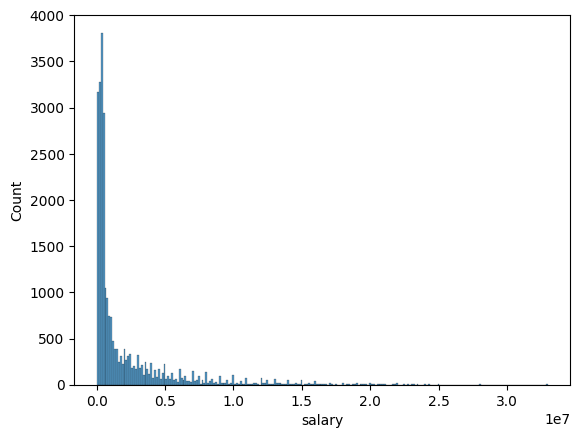

In [34]:

sns.histplot(x="salary", data=salaries)

### Logarithmic Scaling
When preparing data for machine learning models, it's better to have a dataset that is not heavily skewed. Our current salaries dataset shows significant skewness, as observed in the distribution of salary values.

Transforming Data with Logarithms
A common and effective technique to address skewness in data is through logarithmic scaling, here's a brief explanation:

The logarithm of a number  𝑛  with a given base  𝑏  is denoted as  log𝑏(𝑛)  and is defined as the exponent  𝑥  to which the base  𝑏  must be raised to produce  𝑛 . Mathematically, it's expressed as:

log𝑏(𝑛)=𝑥⟹𝑏𝑥=𝑛 

In simpler terms, the logarithm tells us how many times we need to multiply the base  𝑏  by itself to get the number  𝑛 .

#### Applying Logarithmic Scaling to Salaries
By applying logarithmic scaling to the salary data, we can transform the wide range of salaries into a more manageable and comparable scale.
For example, using a base of 10, we can compare how many times 10 fits into the minimum and maximum salaries. In this case, 10 fits approximately 4 times into $10,000 and 7 times into $33 million.
This scaling makes it easier for our machine learning model to understand and predict salaries, as it reduces the effect of extreme values and brings the data closer to a 'normal distribution'.

#### Transforming Salary Data with Logarithm
Now we will transform and visualize the salary data in the salaries dataset to better understand its distribution. Transforming the data using a logarithmic scale can help reduce skewness and make patterns in the data more apparent.

In the code cell below we will:
Create a new column in the salaries dataset named "LogSalary".
This column should contain the logarithm of each player's salary.
Once the new column is added, plot the distribution of the transformed salaries.

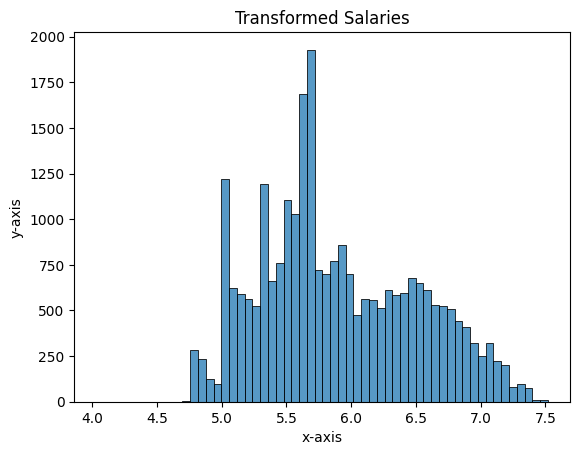

In [35]:
salaries["LogSalary"] = np.log10(salaries["salary"])


sns.histplot(x="LogSalary", data=salaries).set(title='Transformed Salaries', xlabel='x-axis', ylabel='y-axis')
plt.show()

### Examining the Year Feature
Now that we've explored the batting and salaries datasets, we can focus on using batting data to predict salaries. We will merge these datasets to create a larger dataset where each row contains information for a specific playerID and year combination. This merged dataset will have a player's stats and salary for a given year.

However, there's an issue. If each row contains batting statistics and salaries for the same year, the statistics wouldn't help us predict the salary the player is already earning that year. To address this, we should ensure that the batting statistics are paired with the salary from the following year. This way, the models we create will predict future salaries based on current batting statistics. We will simulate this by offsetting the salary data.

As an example, if we have statistics on Yu Darvish's pitching stats in 2016, this would be used to predict the salary he would earn in 2017.

In the code cell below, we'll create a new column year_salary in the batting dataset. This column will link a player's batting data in one year to his salary in the following year.

In [36]:
batting['year_salary'] = batting['year'] + 1
batting.sample(5)

,playerID,year,SeasonsPlayed,Games,AtBats,Runs,Hits,Doubles,Triples,HomeRuns,...,HitsByPitch,SacrificeHits,SacrificeFlies,GroundedIntoDoublePlays,BattingAverage,OnBasePercentage,SluggingPercentage,isArbitrationEligible,isFreeAgent,year_salary
32284,thompja01,1983,7,152,517,70,134,20,1,18,...,1.0,0.0,6.0,14.0,0.259188,0.375602,0.406190,False,True,1984
18554,larkiba01,2002,16,145,507,72,124,37,2,7,...,3.0,6.0,7.0,13.0,0.244576,0.304813,0.366864,False,True,2003
15899,inciaen01,2019,5,65,199,30,49,11,2,5,...,4.0,0.0,1.0,1.0,0.246231,0.343478,0.396985,True,False,2020
9604,erstada01,2002,6,150,625,99,177,28,4,10,...,2.0,5.0,4.0,9.0,0.283200,0.313070,0.388800,False,True,2003
24419,olsoniv01,1916,5,108,351,29,89,13,4,1,...,1.0,20.0,0.0,0.0,0.253561,0.297587,0.321937,True,False,1917


### Clarification on Merging Datasets
Now that we've created a new column in the batting dataset to indicate the corresponding salary year for each row of batting features. This new column, named year_salary, matches the year column in the salaries dataset. Because of this, we can easily merge the two datasets using these columns to align each player's batting statistics with the correct salary year.

Merging Datasets: Linking Player Data with Salaries
After exploring individual datasets, our next step is to integrate the player data with their salary information. This will allow us to analyze how player performance metrics correlate with their compensation.


In [37]:
merged_data = pd.merge(batting, salaries, on=['playerID', 'year_salary'])
merged_data.sample(5)

,playerID,year,SeasonsPlayed,Games,AtBats,Runs,Hits,Doubles,Triples,HomeRuns,...,GroundedIntoDoublePlays,BattingAverage,OnBasePercentage,SluggingPercentage,isArbitrationEligible,isFreeAgent,year_salary,teamID,salary,LogSalary
9818,wellsve01,2003,1,161,678,118,215,49,5,33,...,21.0,0.317109,0.359184,0.550147,False,False,2004,TOR,870000,5.939519
2318,dejesda01,2009,5,144,558,74,157,28,9,13,...,10.0,0.281362,0.347267,0.433692,True,False,2010,KCA,4700000,6.672098
4760,jeffegr01,1990,1,153,604,96,171,40,3,15,...,12.0,0.283113,0.336874,0.433775,False,False,1991,NYN,425000,5.628389
9344,troutmi01,2014,2,157,602,115,173,39,9,36,...,6.0,0.287375,0.377305,0.561462,False,False,2015,LAA,6083000,6.784118
1224,brunato01,1985,3,157,567,71,137,28,4,27,...,12.0,0.241623,0.319508,0.447972,True,False,1986,MIN,740000,5.869232


## Milestone 2: Salary Prediction
In this section, we shift our focus to one of the key objectives of our project: predicting baseball players' salaries. We are now ready to apply machine learning techniques to forecast salaries based on various player aspects.

Objectives:

Utilize the enhanced dataset, which includes player performance metrics, experience categories, and other relevant features.
Develop and train machine learning models capable of accurately predicting player salaries.
Experiment with different modeling approaches, such as linear regression, decision trees, or more advanced techniques like random forests or neural networks.
Goals:

Achieve a high degree of accuracy in salary predictions.
Understand the factors that most significantly influence player salaries.
Explore the relationship between player performance, experience, and compensation.
This milestone is crucial for understanding the dynamics of salary determination in professional baseball and showcases the practical application of data science in sports analytics.

Choosing the columns to focus on
In the provided code cell below, we will be able to focus our efforts on the columns of highest interest. Run the cell to choose columns you want to include in your analysis! The code cell will handle creating an X variable with scaled versions of the input features you choose, and a y variable with the 'LogSalary' data.


This code below can help the user choose the columns they are interested in.

In [38]:
from ipywidgets import widgets
from sklearn.preprocessing import MinMaxScaler

# Columns to exclude from the checkboxes
exclude_columns = ['playerID', 'teamID', 'salary', 'year', 'year_salary', 'LogSalary']

# Create checkboxes for each column, excluding specific ones
checkboxes = {col:
                widgets.Checkbox(description=col, value=True)
                for col in merged_data.columns if col not in exclude_columns}

# Initial selection
bool_list = [(col not in exclude_columns) and checkboxes[col].value for col in merged_data.columns]
X = merged_data.loc[:, bool_list]
X_scaled = MinMaxScaler().fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)
y = merged_data["LogSalary"]

# Function to update selected_columns based on checkbox values
def update_selected_columns(change):
    global X, bool_list
    bool_list = [(col not in exclude_columns) and checkboxes[col].value for col in merged_data.columns]
    X = merged_data.loc[:, bool_list]
    X_scaled = MinMaxScaler().fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=X.columns)

# Attach the callback to checkbox changes
for checkbox in checkboxes.values():
    checkbox.observe(update_selected_columns, 'value')

# Display checkboxes in a grid
widgets.GridBox(list(checkboxes.values()), layout=widgets.Layout(grid_template_columns="repeat(3, 200px)"))


GridBox(children=(Checkbox(value=True, description='SeasonsPlayed'), Checkbox(value=True, description='Games')…

Now let's split the data.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now its time to initialize, fit, and display the model as a scatterplot.

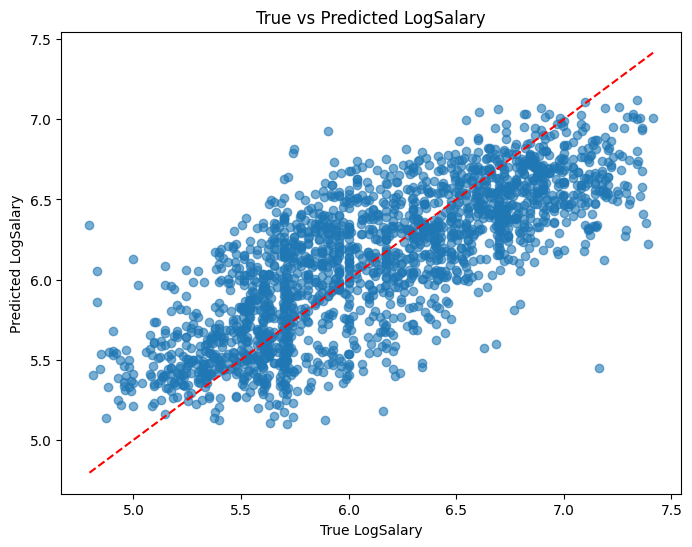

In [40]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

linear_model.score(X_test, y_test)

y_pred = linear_model.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("True LogSalary")
plt.ylabel("Predicted LogSalary")
plt.title("True vs Predicted LogSalary")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.show()


We will take a look at the mean squared error, which is taking the difference between all the predictions and the true value, taking the square of those differences, and then taking the average. Of course, to have a good model, we'd want this value to be small.

In [41]:
predictions = linear_model.predict(X_test)
mean_squared_error(y_test, predictions)

0.13816737931818424

Now, we will take a look at how the linear model weighs each of the input variables! We'll do this by taking a look at the relative magnitude of the coefficients of each input. Basically, we are taking the line of best fit 𝑦=𝑚1𝑥1+𝑚2𝑥2+... found from the linear regression and seeing which of the 𝑚s is largest in size, regardless of sign. A larger size coefficient means a given change in the input feature 𝑥 will have a larger effect on the overall output than a feature with a smaller coefficient!

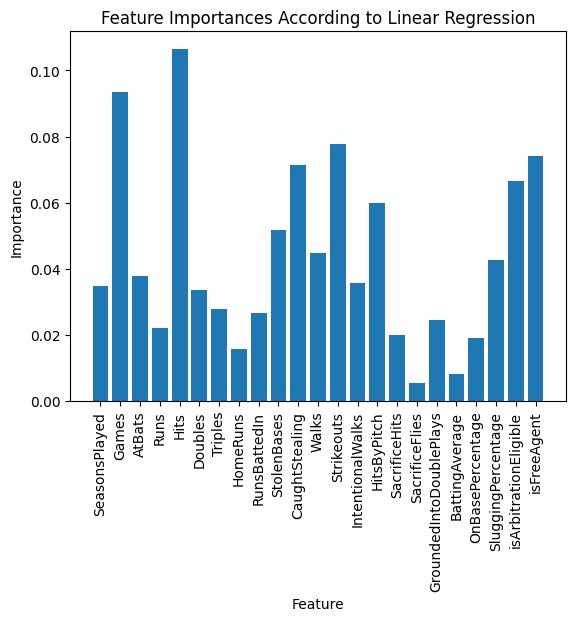

In [42]:

# Get absolute values of the coefficients of the model
linear_model_importances = np.abs(linear_model.coef_)

# Normalize feature importances
linear_model_importances /= linear_model_importances.sum()

# Plot feature importances
plt.bar(X.columns, linear_model_importances, label='Linear Regression')
plt.title('Feature Importances According to Linear Regression')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

Try a Decision Tree!

This code below tries out the same thing with a decision tree.

In [43]:
dt_model = DecisionTreeRegressor(max_depth=3)
dt_model.fit(X_train, y_train)
predictions = dt_model.predict(X_test)

print(f"R^2: {dt_model.score(X_test, y_test)}")
print(f"MSE: {mean_squared_error(y_test, predictions)}")

R^2: 0.5298380101046571
MSE: 0.15945861982111814


##### Other regression models below:

RandomForest: basically a "forest" of decision trees that are each fit on different samples of the data. We determine the prediction by feeding the input to all the trees and taking the average of their predictions.
MLPRegressor: a fully connected neural network.

In [44]:
models = [RandomForestRegressor(max_depth=3),
          MLPRegressor(hidden_layer_sizes=(64,32)),
          ]

for model in models:
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)

  print(type(model).__name__)
  print(f"  R^2: {model.score(X_test, y_test)}")
  print(f"  MSE: {mean_squared_error(y_test, predictions)}")
  print()

RandomForestRegressor
  R^2: 0.5529256139340348
  MSE: 0.15162830277990258

MLPRegressor
  R^2: 0.6230607656791816
  MSE: 0.12784149155614707



## Milestone 3: Finding the most undervalued players
Now that we've explored some models to predict player salaries, let's take a look at who might be undervalued according to our model!

To identify the most undervalued players, we will take a look at the predicted LogSalary and compare it to the actual value. 

In [45]:
predictions = linear_model.predict(X)
merged_data['LogSalaryDifference'] = predictions - merged_data['LogSalary']
merged_data.sample(5)

,playerID,year,SeasonsPlayed,Games,AtBats,Runs,Hits,Doubles,Triples,HomeRuns,...,BattingAverage,OnBasePercentage,SluggingPercentage,isArbitrationEligible,isFreeAgent,year_salary,teamID,salary,LogSalary,LogSalaryDifference
1747,ceyro01,1985,12,145,500,64,116,18,2,22,...,0.232000,0.315603,0.408000,False,True,1986,CHN,1400000,6.146128,0.402394
2777,escobyu01,2010,3,135,497,60,127,19,0,4,...,0.255533,0.336918,0.317907,True,False,2011,TOR,2900000,6.462398,-0.154748
10104,woodwch01,2002,0,90,312,48,86,13,4,13,...,0.275641,0.329513,0.467949,False,False,2003,TOR,775000,5.889302,-0.167607
9326,treanma01,2005,0,58,134,10,27,8,0,0,...,0.201493,0.300654,0.261194,False,False,2006,FLO,327000,5.514548,-0.124007
4557,huntebr02,2002,7,98,201,32,54,16,3,3,...,0.268657,0.328767,0.422886,False,True,2003,HOU,1200000,6.079181,-0.022956


Now what does this difference really mean? Let's dive back into the math. Here's what we have above:

LogSalaryDifference=log10(salarypred)−log10(salarytrue) 

A rule of logarithms is that this is equivalent to

LogSalaryDifference=log10(salarypred/salarytrue) 

Another nifty rule of the logarithm we're using is that

10log10𝑥=𝑥 

Putting all of this together, we have the following:

10^LogSalaryDifference = 10^(log10(salarypred/salarytrue)) = salarypred/salarytrue

meaning we can get the ratio of the predicted salary to the true salary by taking the exponent of our LogSalaryDifference column!

We've written the code below that adds a new column with this calculation, using np.power() which will do that  10𝑥  calculation for every value in the input column.

In [46]:
merged_data['SalaryRatio'] = np.power(10, merged_data['LogSalaryDifference'])

The code below will sort the data by this ratio, and will show us the most under/overvalued players according to our model.

In [47]:
merged_data.sort_values('SalaryRatio')

,playerID,year,SeasonsPlayed,Games,AtBats,Runs,Hits,Doubles,Triples,HomeRuns,...,OnBasePercentage,SluggingPercentage,isArbitrationEligible,isFreeAgent,year_salary,teamID,salary,LogSalary,LogSalaryDifference,SalaryRatio
3159,fukudko01,2010,2,130,358,45,94,20,2,13,...,0.370892,0.438547,False,False,2011,CHN,14500000,7.161368,-1.714578,0.019294
1657,castiru01,2015,0,80,273,35,69,10,2,5,...,0.288194,0.358974,False,False,2016,BOS,11400000,7.056905,-1.546098,0.028438
3805,guerral01,2015,0,106,219,25,51,9,1,11,...,0.260870,0.433790,False,False,2016,LAN,7500000,6.875061,-1.477213,0.033326
6092,matsuka01,2005,1,87,267,31,68,9,4,3,...,0.300000,0.352060,False,False,2006,NYN,8033333,6.904896,-1.420146,0.038006
3158,fukudko01,2009,1,146,499,79,129,38,5,11,...,0.375000,0.420842,False,False,2010,CHN,14000000,7.146128,-1.325969,0.047210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4122,hatchmi01,1986,5,115,317,40,88,13,3,3,...,0.314706,0.365931,True,False,1987,LAN,62500,4.795880,1.148438,14.074652
533,baylodo01,1986,14,160,585,93,139,23,1,31,...,0.343523,0.439316,False,True,1987,OAK,731123,5.863990,1.155687,14.311548
9763,wardga01,1988,7,91,231,26,52,8,0,4,...,0.302326,0.311688,False,True,1989,NYA,68000,4.832509,1.221347,16.647407
1834,clarkja01,1992,15,81,257,32,54,11,0,5,...,0.350000,0.311284,False,True,1993,MON,109000,5.037426,1.348371,22.303413


### That's all for part 2

In part 3, we will look into expanding this budget optimization through cluster analysis and other machine learning to cluster players.